# Torchvision Transforms V2

Dataset: [Embrapa Wine Grape Instance Segmentation Dataset](https://github.com/thsant/wgisd)

Download:
```
git clone https://github.com/thsant/wgisd.git
```

## Configuration

Imports

In [1]:
import warnings

In [2]:
warnings.simplefilter('ignore')

In [3]:
from pathlib import Path
from collections import defaultdict
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tqdm
import tqdm.autonotebook
tqdm.autonotebook.tqdm = tqdm.tqdm # hack to force ASCII output everywhere
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import ops, tv_tensors, io
import torchvision.transforms.v2 as transforms
import torchvision.transforms.v2.functional as TF

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [4]:
WGISD_ROOT = Path('./wgisd/')
DATA_DIR = WGISD_ROOT / 'data'
TRAIN_LIST = WGISD_ROOT / 'train.txt'
TEST_LIST = WGISD_ROOT / 'test.txt'

MODELS_DIR = Path('./models')

VAL_RATIO = 0.1

IMAGE_SIZE = 512

NUM_WORKERS = 8
BATCH_SIZE = 16
EPOCHS = 1000

LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-2

In [5]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

### Reading bounding box information

In [6]:
def get_file_list(list_name):
    with open(list_name) as f:
        file_list = f.readlines()
    file_list = [file_name.strip() for file_name in file_list]
    return file_list

In [7]:
def read_annotation(annotation_path):
    bboxes = []
    try:
        with open(annotation_path) as f:
            for line in f:
                label, x_center, y_center, width, height = [float(s) for s in line.split()]
                x1 = max(x_center - 0.5 * width, 0.)
                y1 = max(y_center - 0.5 * height, 0.)
                x2 = min(x_center + 0.5 * width, 1.)
                y2 = min(y_center + 0.5 * height, 1.)
                if x1 < x2 and y1 < y2:
                    bbox = [x1, y1, x2, y2]
                    bboxes.append(bbox)
                else:
                    print("Invalid bounding box", annotation_path)
    
    except FileNotFoundError:
        print("Annotation missing:", annotation_path)

    return bboxes

In [8]:
def denormalize_bounding_boxes(bboxes, shape):
    w, h = shape
    new_bboxes = []
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        new_bbox = [x1 * w, y1 * h, x2 * w, y2 * h]
        new_bboxes.append(new_bbox)
    return new_bboxes

In [9]:
def read_bounding_boxes(file_list):
    images_data = []
    for name in file_list:
        image_name = name + '.jpg'
        image_path = DATA_DIR / image_name
        image = Image.open(image_path)
        shape = image.size

        annotation_name = name + '.txt'
        annotation_path = DATA_DIR / annotation_name
        bboxes = read_annotation(annotation_path)
        bboxes = denormalize_bounding_boxes(bboxes, shape)
        
        data = {'file_name': image_path, 'bboxes': bboxes, 'shape': shape}
        images_data.append(data)
            
    return images_data

In [10]:
train_val_list = get_file_list(TRAIN_LIST)

In [11]:
test_list = get_file_list(TEST_LIST)

In [12]:
train_list, val_list = train_test_split(train_val_list, test_size=VAL_RATIO, random_state=0,
                                        shuffle=True)

In [13]:
print("Number of train images:", len(train_list))
print("Number of validation images:", len(val_list))
print("Number of train+validation images:", len(train_list) + len(val_list))
print("Number of test images:", len(test_list))
print("Total number of images:", len(train_list) + len(val_list) + len(test_list))

Number of train images: 217
Number of validation images: 25
Number of train+validation images: 242
Number of test images: 58
Total number of images: 300


In [14]:
train_data = read_bounding_boxes(train_list)
val_data = read_bounding_boxes(val_list)
test_data = read_bounding_boxes(test_list)

### Utilities

Plotting

In [15]:
def plot_image(image):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(image)
    plt.show()

In [16]:
def plot_image_bounding_boxes(image, bboxes, bboxes_gt=None):
    image = TF.convert_image_dtype(image, dtype=torch.uint8)
    image_bboxes = torchvision.utils.draw_bounding_boxes(image=image, boxes=bboxes, colors='red', width=2)
    if bboxes_gt is not None:
        image_bboxes = torchvision.utils.draw_bounding_boxes(image=image_bboxes, boxes=bboxes_gt, colors='blue', width=2)
    image_bboxes = TF.to_pil_image(image_bboxes)
    plot_image(image_bboxes)

### Dataset

In [17]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(
        degrees=10.,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=8.
    ),
    transforms.RandomPhotometricDistort(p=1),
    transforms.ClampBoundingBoxes(),
    transforms.SanitizeBoundingBoxes(labels_getter=None),
    transforms.ToDtype(torch.float32, scale=True),
])

In [18]:
val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    transforms.ToDtype(torch.float32, scale=True),
])

In [19]:
class ImagesDataset(torch.utils.data.Dataset):
    def __init__(self, images_data, transform):
        self.images_data = images_data
        self.transform = transform
    
    def __len__(self):
        return len(self.images_data)
    
    def __getitem__(self, idx):
        img_data = self.images_data[idx]
        file_path = img_data['file_name']
        image = tv_tensors.Image(io.read_image(str(file_path)))

        bboxes = img_data['bboxes']
        if len(bboxes) == 0: bboxes = torch.zeros((0, 4), dtype=torch.float32)

        bboxes = tv_tensors.BoundingBoxes(bboxes, format=tv_tensors.BoundingBoxFormat.XYXY, canvas_size=image.shape[1:])
        image, bboxes = self.transform(image, bboxes)
       
        return image, bboxes
    
    def show_image(self, idx):
        image, bboxes = self[idx]
        plot_image_bounding_boxes(image, bboxes)

In [20]:
train_dset = ImagesDataset(train_data, train_transform)

In [21]:
val_dset = ImagesDataset(val_data, val_transform)

In [22]:
test_dset = ImagesDataset(test_data, val_transform)

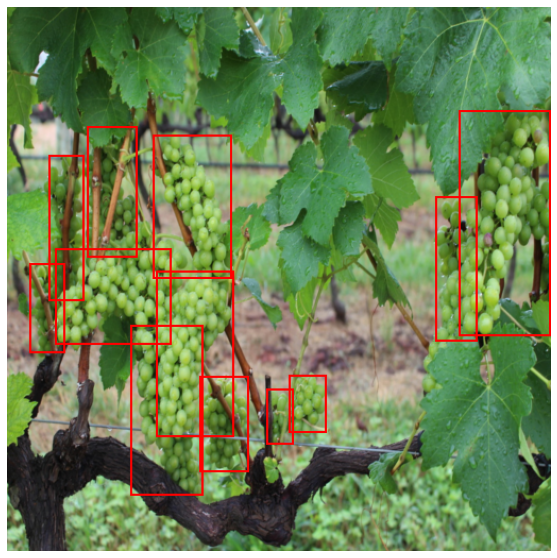

In [23]:
val_dset.show_image(0)

### DataLoader

Normalize bounding boxes

In [24]:
def normalize_bboxes(bboxes):
    h, w = bboxes.canvas_size
    wh = torch.tensor([w, h])
    bboxes = torch.cat((bboxes[:, :2] / wh, bboxes[:, 2:] / wh), axis=1)
    return bboxes

Pad ground truth bounding boxes to allow formation of a batch tensor.

In [25]:
def extend_tensor(t, max_len):
    l = len(t)
    if l < max_len:
        z = torch.zeros((max_len - l,) + t.shape[1:])
        return torch.cat((t, z), dim=0)
    else:
        return t

In [26]:
def collate_fn(batch):
    images, bboxes = zip(*batch)
    
    images_tens = torch.stack(images, dim=0)

    max_bboxes = max(len(bbs) for bbs in bboxes)
    bboxes_tens = [extend_tensor(normalize_bboxes(bbs), max_bboxes) for bbs in bboxes]
    bboxes_tens = torch.stack(bboxes_tens, dim=0)

    return images_tens, bboxes_tens

In [27]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           collate_fn=collate_fn,
                                           num_workers=NUM_WORKERS, pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False,
                                         collate_fn=collate_fn,
                                         num_workers=NUM_WORKERS, pin_memory=True)

In [28]:
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          collate_fn=collate_fn,
                                          num_workers=NUM_WORKERS, pin_memory=True)

## Model

Model can have architecture similar to segmentation models.

For each cell in the output model proposes a bounding box with the center in that cell and a score.

### Encoder

In [29]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, act=True):
        padding = (kernel_size - 1) // 2
        layers = [
          nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
          nn.BatchNorm2d(out_channels)
        ]
        if act: layers.append(nn.ReLU(inplace=True))
        super().__init__(*layers)

In [30]:
class DownBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels, 3)
        )

In [31]:
class Encoder(nn.Module):
    def __init__(self, in_channels, channels, num_downsamplings):
        super().__init__()
        self.stem = ConvBlock(in_channels, channels, 3)
        
        self.blocks = nn.ModuleList()
        in_channels = channels
        for _ in range(num_downsamplings):
            out_channels = in_channels * 2
            self.blocks.append(DownBlock(in_channels, out_channels))
            in_channels = out_channels
    
    def forward(self, x):
        x = self.stem(x)
        
        xs = []
        for block in self.blocks:
            xs.append(x)
            x = block(x)
        return x, xs

### Decoder

In [32]:
class UpBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            ConvBlock(in_channels, out_channels, 3, act=False),
            nn.Upsample(scale_factor=2, mode='nearest')
        )

In [33]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = UpBlock(in_channels, out_channels)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.act = nn.ReLU(inplace=True)
    
    def forward(self, x, skip):
        x = self.up(x)
        out = skip + self.gamma * x
        return self.act(out)    

In [34]:
class Head(nn.Sequential):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__(
            ConvBlock(in_channels, hidden_channels, 3),
            nn.Conv2d(hidden_channels, out_channels, kernel_size=1)
        )

In [35]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, num_upsamplings):
        super().__init__()
        self.up = nn.ModuleList()
        for _ in range(num_upsamplings):
            channels = in_channels // 2
            self.up.append(Up(in_channels, channels))
            in_channels = channels
        
        self.head = Head(channels, channels, out_channels)
    
    def forward(self, x, xs):
        for up_layer, skip in zip(self.up, reversed(xs)):
            x = up_layer(x, skip)
        x = self.head(x)
        return x

### Full model

In [36]:
class Net(nn.Module):
    def __init__(self, num_downsamplings, num_upsamplings, channels=32, in_channels=3):
        super().__init__()
        self.encoder = Encoder(in_channels, channels, num_downsamplings)
        self.decoder = Decoder(channels * 2**num_downsamplings, 5, num_upsamplings)

    def forward(self, x):
        x, xs = self.encoder(x)
        out = self.decoder(x, xs)
        out = torch.sigmoid(out)
        boxes = self.to_boxes(out)
        return boxes
        
    def to_boxes(self, out):
        h, w = out.shape[2:]

        grid_x = torch.arange(w, device=out.device).unsqueeze(0)
        grid_y = torch.arange(h, device=out.device).unsqueeze(1)
        cx = (out[:, 0] + grid_x) / w
        cy = (out[:, 1] + grid_y) / h
        pred_w = out[:, 2]
        pred_h = out[:, 3]
        
        x1 = cx - 0.5 * pred_w
        y1 = cy - 0.5 * pred_h
        x2 = cx + 0.5 * pred_w
        y2 = cy + 0.5 * pred_h
        
        scores = out[:, 4]
        boxes = torch.stack((x1, y1, x2, y2, scores), dim=3)
        return boxes

In [37]:
def init_model(model):
    for m in model.modules():
        if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None: nn.init.zeros_(m.bias)

In [38]:
model = Net(num_downsamplings=5, num_upsamplings=3, channels=32).to(DEVICE)

In [39]:
init_model(model)

In [40]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 12,633,512


## Loss

In [41]:
def batch_box_area(boxes):
    return (boxes[..., 2] - boxes[..., 0]) * (boxes[..., 3] - boxes[..., 1])

In [42]:
def batch_box_scores(boxes_gt,   # shape: (b, n_gt, 4)
                     boxes_pred, # shape: (b, n_pred, 4)
                     eps=1e-7):
    
    lt = torch.max(boxes_gt[..., None, :2], boxes_pred[..., None, :, :2])
    rb = torch.min(boxes_gt[..., None, 2:], boxes_pred[..., None, :, 2:])

    wh = (rb - lt).clamp(min=0) 
    inter = wh[..., 0] * wh[..., 1] # shape: (b, n_gt, n_pred)
    
    area_gt = batch_box_area(boxes_gt)[..., None]
    area_pred = batch_box_area(boxes_pred)[..., None, :]
    
    scores = (2 * inter - area_pred) / (area_gt + eps)
    return scores

In [43]:
class DetectionLoss(nn.Module):
    def __init__(self, λ_conf=1.0, λ_geom=1.0):
        super().__init__()
        self.λ_conf = λ_conf
        self.λ_geom = λ_geom
        self.conf_loss = nn.BCELoss()
    
    def forward(self, output, target):
        if target.size(1) == 0:
            target = torch.zeros((target.size(0), 1, 4), device=target.device)

        output = output.flatten(1, 2)
        pred_bboxes = output[..., :4]
        pred_scores = output[..., 4]

        true_scores = batch_box_scores(target, pred_bboxes)
        true_scores, _ = torch.max(true_scores, dim=1)

        conf_loss = self.conf_loss(pred_scores, true_scores.clamp(min=0.).detach())
        geom_loss = 1. - torch.mean(true_scores)
        loss = self.λ_conf * conf_loss + self.λ_geom * geom_loss
        return loss

## Metrics

Output preprocessing

from https://github.com/xingyizhou/CenterNet

In [44]:
def heatmap_peaks(heat, kernel=3):
    pad = (kernel - 1) // 2
    hmax = nn.functional.max_pool2d(heat.unsqueeze(1), (kernel, kernel), stride=1, padding=pad).squeeze(1)
    peaks = (hmax == heat)
    return peaks

In [45]:
def remove_zero_boxes(boxes):
    mask = ~ (boxes == 0.).all(dim=-1)
    return boxes[mask]

In [46]:
class DetectionMetrics(ignite.metrics.Metric):
    def __init__(self, threshold=0.5, iou_threshold=0.5, nms_threshold=0.5, heatmap_kernel=3,
                 output_transform=lambda x: x, device="cpu"):
        self.threshold = threshold
        self.iou_threshold = iou_threshold
        self.nms_threshold = nms_threshold
        self.heatmap_kernel = heatmap_kernel
        super().__init__(output_transform=output_transform, device=device)
    
    def reset(self):
        self._num_true = 0
        super().reset()
    
    def update(self, data):
        outputs, true_bboxes = data[0].detach(), data[1].detach()
        
        pred_ious = outputs[..., 4]
        pred_bboxes = outputs[..., :4]
        
        peaks = heatmap_peaks(pred_ious, kernel=self.heatmap_kernel)
        masks = peaks & (pred_ious > self.threshold)
        
        for true_boxes, pred_boxes, conf, mask in zip(true_bboxes, pred_bboxes, pred_ious, masks):
            true_boxes = remove_zero_boxes(true_boxes)
            
            pred_boxes = pred_boxes[mask]
            conf = conf[mask]
            
            keep_idx = ops.nms(pred_boxes, conf, self.nms_threshold)
            pred_boxes = pred_boxes[keep_idx]
            conf = conf[keep_idx]
            
            if len(pred_boxes) > 0 and len(true_boxes) > 0:
                ious = ops.box_iou(pred_boxes, true_boxes)
                
                # zero all non_maximum values for a given ground truth box
                idx = ious.argmax(dim=0, keepdims=True)
                ious = torch.zeros_like(ious).scatter_(0, idx, ious.gather(0, idx))
                
                is_true_positive = ious > self.iou_threshold
                is_true_positive = is_true_positive.any(dim=1)
            else:
                is_true_positive = torch.zeros_like(conf, dtype=torch.bool)
            
            self._num_true += len(true_boxes)
            self.process_batch(is_true_positive, conf)

Simple F1 score for evaluation during training

In [47]:
class F1(DetectionMetrics):
    def reset(self):
        self._num_pred = 0
        self._num_tp = 0
        super().reset()
    
    def process_batch(self, is_true_positive, conf):
        self._num_pred += len(conf)
        self._num_tp += is_true_positive.sum().item()
    
    def compute(self):
        prec = self._num_tp / (self._num_pred + 1e-7)
        rec = self._num_tp / (self._num_true + 1e-7)
        f1 = 2 * prec * rec / (prec + rec + 1e-7)
        return f1

Average precsion AP using all-point interpolation

In [48]:
class AveragePrecision(DetectionMetrics):
    def __init__(self, iou_threshold=0.5, nms_threshold=0.5, heatmap_kernel=3,
                 output_transform=lambda x: x, device="cpu"):
        super().__init__(threshold=0., iou_threshold=iou_threshold,
                         nms_threshold=nms_threshold, heatmap_kernel=heatmap_kernel,
                         output_transform=output_transform, device=device)
    
    def reset(self):
        self._tp_list = []
        self._confidence_list = []
        super().reset()
    
    def process_batch(self, is_true_positive, conf):
        self._confidence_list.append(conf)
        tp = torch.zeros_like(conf)
        tp[is_true_positive] = 1.
        self._tp_list.append(tp)
    
    def compute(self):
        conf = torch.cat(self._confidence_list)
        tp = torch.cat(self._tp_list)
        
        # sort true positives according to confidence
        idx = conf.argsort(descending=True)
        tp = tp[idx]
        
        # cumulative sum of true positives and false positives
        tpc = tp.cumsum(0)
        fpc = (1. - tp).cumsum(0)
        
        # precision and recall curves
        recall = tpc / (self._num_true + 1e-7)
        precision =  tpc / (tpc + fpc)
        
        # append sentinel values to beginning and end
        z = torch.zeros(1, device=self._device)
        o = torch.ones(1, device=self._device)
        recall = torch.cat([z, recall, o])
        precision = torch.cat([o, precision, z])
        
        # compute precision envelope
        precision = precision.flip(0)
        precision, _ = precision.cummax(0)
        precision = precision.flip(0)
        
        # integrate area under curve
        idx = (recall[1:] != recall[:-1]).nonzero(as_tuple=True)[0] # indexes where recall changes
        ap = ((recall[idx + 1] - recall[idx]) * precision[idx + 1]).sum().item() # area under curve
        
        return ap

## Training

### Setup Trainer

In [49]:
params = [p for p in model.parameters() if p.requires_grad]

In [50]:
optimizer = optim.AdamW(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [51]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [52]:
loss = DetectionLoss()

Trainer

In [53]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [54]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [55]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [56]:
pbar = ignite.contrib.handlers.ProgressBar(persist=True, ncols=100)

In [57]:
pbar.attach(trainer, event_name=Events.EPOCH_COMPLETED, closing_event_name=Events.COMPLETED)

Evaluator

In [58]:
evaluator = create_supervised_evaluator(model,
                metrics={"F1": F1(device=DEVICE), "loss": ignite.metrics.Loss(loss)},
                device=DEVICE)

In [59]:
best_handler = ignite.handlers.Checkpoint({'model': model},
    ignite.handlers.DiskSaver(MODELS_DIR, create_dir=False, require_empty=False),
    n_saved=1, filename_prefix='best',
    score_function=ignite.handlers.Checkpoint.get_default_score_fn("F1"),
    score_name="val_F1",
    global_step_transform=ignite.handlers.global_step_from_engine(trainer)
)

In [60]:
evaluator.add_event_handler(Events.COMPLETED, best_handler);

In [61]:
history = defaultdict(list)

In [62]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)
    
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_f1 = val_metrics["F1"]
    history['val loss'].append(val_loss)
    history['val F1'].append(val_f1)
    
    pbar.pbar.set_postfix({"train loss": f"{train_loss:.3f}",
                           "val loss": f"{val_loss:.3f}", "val F1": f"{val_f1:.3f}"})

### Start training

In [63]:
trainer.run(train_loader, max_epochs=EPOCHS);

Epoch: [1000/1000] 100%|████████████, train loss=1.038, val loss=1.049, val F1=0.778 [1:31:48<00:00]


In [64]:
torch.save(model.state_dict(), str(MODELS_DIR / 'final_model.pt'))

### Plotting

In [65]:
def show_or_save(fig, filename=None):
    if filename:
        fig.savefig(filename, bbox_inches='tight', pad_inches=0.05)
        plt.close(fig)
    else:
        plt.show()

In [66]:
def history_plot_train_val(history, key, filename=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
    show_or_save(fig, filename)

In [67]:
def history_plot(history, key, filename=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history[key]) + 1)
    ax.plot(xs, history[key], '.-')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.grid()
    show_or_save(fig, filename)

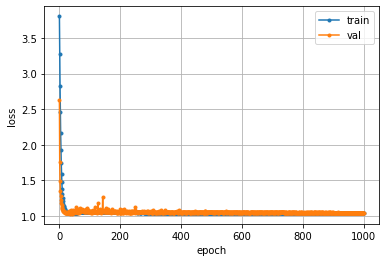

In [68]:
history_plot_train_val(history, 'loss')

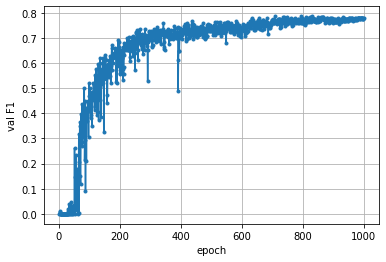

In [69]:
history_plot(history, 'val F1')

## Testing

In [70]:
def evaluate_metric(model, metric, loader, device, **kwargs):
    name = metric.__name__
    evaluator = create_supervised_evaluator(model,
                metrics={name: metric(device=device, **kwargs)},
                device=device)
    evaluator.run(loader)
    val_metric = evaluator.state.metrics[name]
    return val_metric

In [71]:
#model.load_state_dict(torch.load(best_handler.last_checkpoint))
model.load_state_dict(torch.load(str(MODELS_DIR / 'final_model.pt')))

<All keys matched successfully>

In [72]:
model.eval();

In [73]:
thresholds = np.linspace(0., 1.0, num=50)
f1_vs_thr = [evaluate_metric(model, F1, val_loader, DEVICE, threshold=thr) for thr in tqdm(thresholds)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.21it/s]


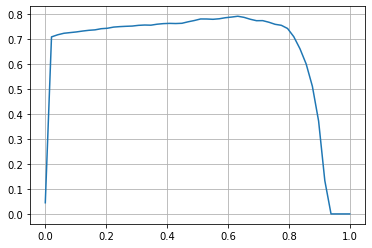

In [74]:
plt.plot(thresholds, f1_vs_thr);
plt.grid();

In [75]:
num = np.argmax(f1_vs_thr)
best_thr = thresholds[num]
best_f1 = f1_vs_thr[num]
print(f"Best F1 {best_f1:.3f} for threshold {best_thr:.3f}")

Best F1 0.791 for threshold 0.633


In [76]:
test_f1 = evaluate_metric(model, F1, test_loader, DEVICE, threshold=best_thr)
print(f"Test F1: {test_f1:.3f}")

Test F1: 0.811


In [77]:
test_ap = evaluate_metric(model, AveragePrecision, test_loader, DEVICE)
print(f"Test AP: {test_ap:.3f}")

Test AP: 0.775


### Example

Convert from scaled tensors to unscaled bounding boxes

In [78]:
def denormalize_bboxes(bboxes, shape):
    wh = torch.tensor([shape[1], shape[0]])
    bboxes = torch.cat((bboxes[:, :2] * wh, bboxes[:, 2:] * wh), axis=1)
    return bboxes

In [79]:
def output_to_bboxes(output, shape, threshold=0.5, nms_threshold=0.5, heatmap_kernel=3):
    pred_ious = output[..., 4]
    pred_boxes = output[..., :4]
    
    peaks = heatmap_peaks(pred_ious.unsqueeze(0), kernel=heatmap_kernel).squeeze(0)
    mask = peaks & (pred_ious > threshold)
    
    pred_boxes = pred_boxes[mask]
    pred_ious = pred_ious[mask]
    
    keep_idx = ops.nms(pred_boxes, pred_ious, nms_threshold)
    pred_boxes = pred_boxes[keep_idx]
    pred_ious = pred_ious[keep_idx]
    
    bboxes = denormalize_bboxes(pred_boxes, shape)
    
    return bboxes, pred_ious

In [80]:
image, bboxes_gt = test_dset[0]

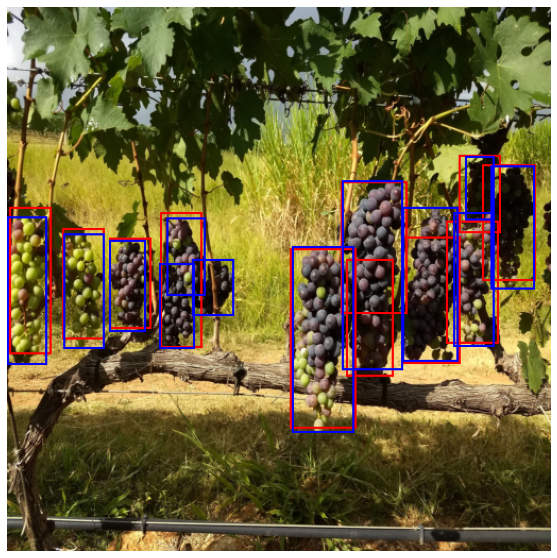

In [81]:
with torch.no_grad():
    output = model(image.unsqueeze(0).to(DEVICE))
output = output.detach().cpu().squeeze(0)
pred_bboxes, pred_scores = output_to_bboxes(output, image.shape[1:], threshold=0.6, nms_threshold=0.5, heatmap_kernel=3)
plot_image_bounding_boxes(image, pred_bboxes, bboxes_gt)

Heatmap of predicted scores

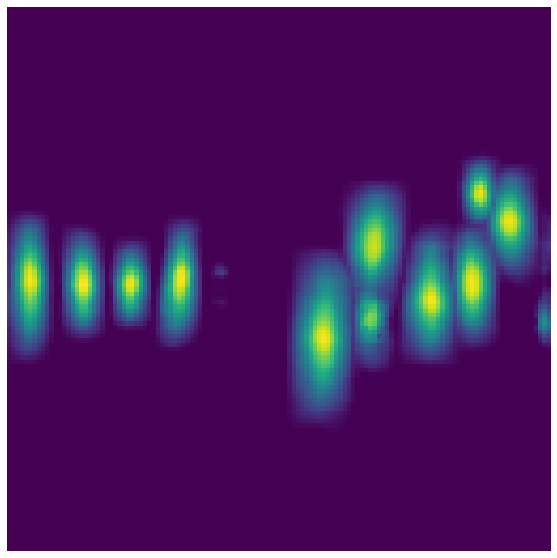

In [82]:
plot_image(TF.to_pil_image(output[..., 4]))